In [1]:
import json

import joblib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import loguniform, randint
import seaborn as sn

In [2]:
with open("../config.json") as json_data_file:
    general_config = json.load(json_data_file)

dataset_path = general_config["IRMAS_Training_Path"]

In [3]:
df = pd.read_csv("../statistics/instruments_complete_features.csv")
df = df.drop('filename', axis=1)
df = df.drop('length', axis=1)

X = df.iloc[:,:-1]
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,
                                                    random_state = 42)

X_train.shape

(270, 55)

In [4]:
labelencoder = LabelEncoder()
y_train = labelencoder.fit_transform(y_train)
y_test = labelencoder.transform(y_test)
len(labelencoder.classes_)

# To see the mapping, you can create a dictionary using the classes_ attribute
label_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))

print("Label Mapping:", label_mapping)

Label Mapping: {'Acoustic_guitar': 0, 'Bass_drum': 1, 'Cello': 2, 'Clarinet': 3, 'Double_bass': 4, 'Flute': 5, 'Hi-hat': 6, 'Saxophone': 7, 'Snare_drum': 8, 'Violin_or_fiddle': 9}


In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
joblib.dump(scaler, "../scalers/kaggle/kaggle_skl_scaler.joblib")
X_train.shape

(270, 55)

Train SVM Accuracy: 0.9962962962962963
Test SVM Accuracy: 0.8


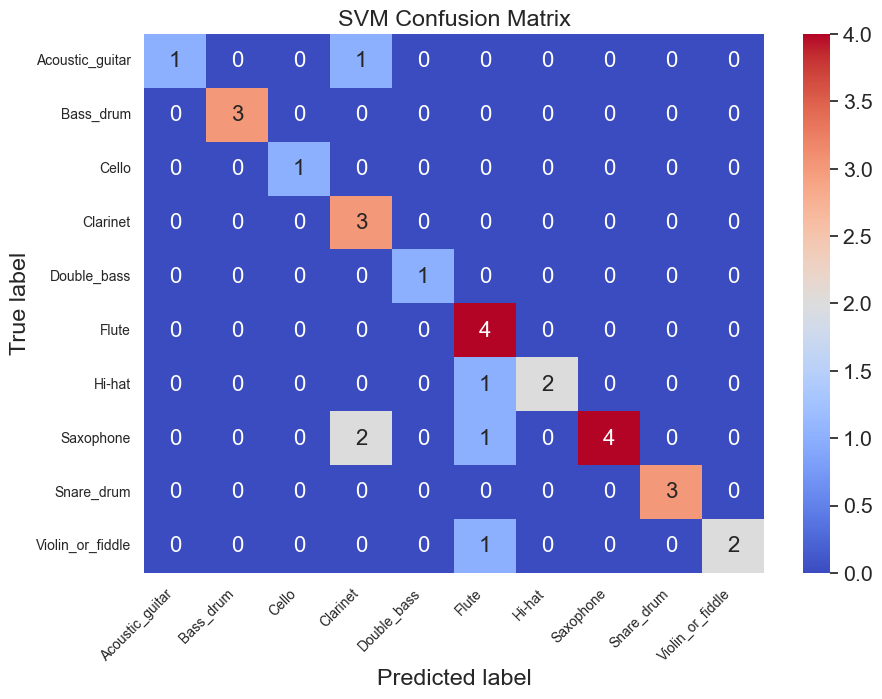

['instrument_models/kaggle_models/kaggle_svm.joblib']

In [6]:
# Define the parameter distribution for SVM
param_dist_svm = {
    'C': loguniform(1e-4, 1e+1),
    'kernel': ['linear', 'rbf'],
    # 'gamma': loguniform(1e-4, 1e-3)
}

svm = SVC(random_state=42)
random_search_svm = RandomizedSearchCV(
    svm, param_distributions=param_dist_svm, n_iter=50,
    scoring='accuracy', n_jobs=-1, random_state=42
)

random_search_svm.fit(X_train, y_train)

best_svm = random_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test)
test_accuracy_svm = accuracy_score(y_test, y_pred_svm)

y_train_pred_svm = best_svm.predict(X_train)
train_accuracy_svm = accuracy_score(y_train, y_train_pred_svm)

print("Train SVM Accuracy:", train_accuracy_svm)
print("Test SVM Accuracy:", test_accuracy_svm)

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred_svm), index=label_mapping.keys(), columns=label_mapping.keys())

plt.figure(figsize=(10, 7))

# Customize seaborn heatmap
sn.set(font_scale=1.4)
heatmap = sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap='coolwarm')

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=10)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('SVM Confusion Matrix')
plt.show()

# Save the model
joblib.dump(value=best_svm, filename="../instrument_models/kaggle_models/kaggle_svm.joblib")

C:\Proiecte SSD\Licenta\Basic-Fourier-Usage\venv\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
135 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
64 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Proiecte SSD\Licenta\Basic-Fourier-Usage\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Proiecte SSD\Licenta\Basic-Fourier-Usage\venv\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Proiecte SSD\Licenta\Basic-Fourier-Usage\venv\lib\site-packages\sklearn\base.py", line 666, in _valid

Train RF Accuracy: 0.9925925925925926
Test RF Accuracy: 0.8


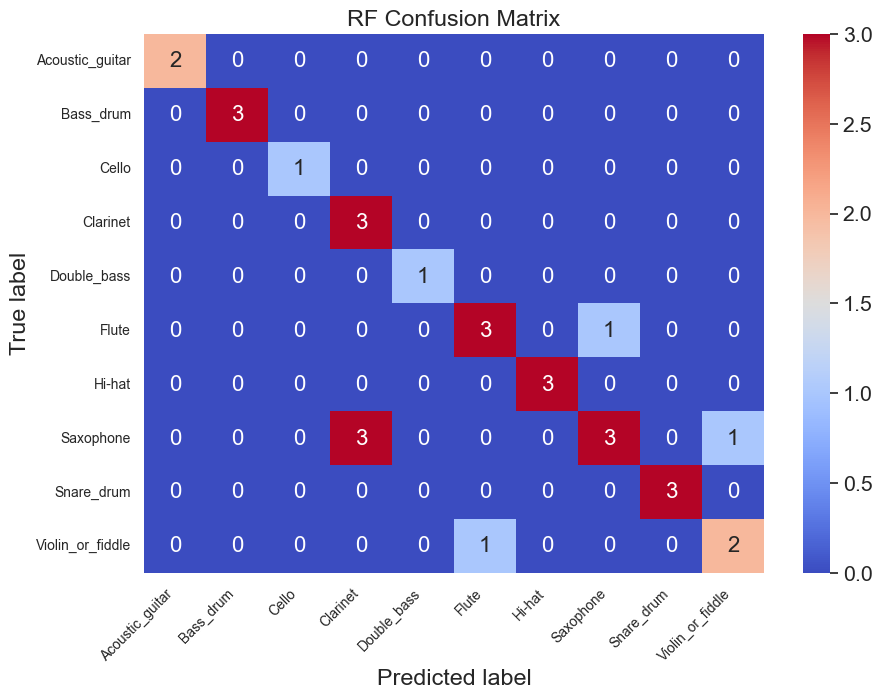

['instrument_models/kaggle_models/kaggle_rf.joblib']

In [7]:
# Define the parameter distribution for Random Forest
param_dist_rf = {
    'n_estimators': randint(10, 101),
    'max_features': ['auto', 'sqrt'],
    'max_depth': randint(1, 31),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
    'bootstrap': [True]
}

rf = RandomForestClassifier(random_state=42)
random_search_rf = RandomizedSearchCV(
    rf, param_distributions=param_dist_rf, n_iter=50,
    scoring='accuracy', n_jobs=-1, random_state=42
)

random_search_rf.fit(X_train, y_train)

best_rf = random_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
test_accuracy_rf = accuracy_score(y_test, y_pred_rf)

y_train_pred_rf = best_rf.predict(X_train)
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)

print("Train RF Accuracy:", train_accuracy_rf)
print("Test RF Accuracy:", test_accuracy_rf)

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred_rf), index=label_mapping.keys(), columns=label_mapping.keys())

plt.figure(figsize=(10, 7))

sn.set(font_scale=1.4)
heatmap = sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap='coolwarm')

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=10)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('RF Confusion Matrix')
plt.show()

# Save the model
joblib.dump(value=best_rf, filename="../instrument_models/kaggle_models/kaggle_rf.joblib")

Train KNN Accuracy: 1.0
Test KNN Accuracy: 0.8333333333333334


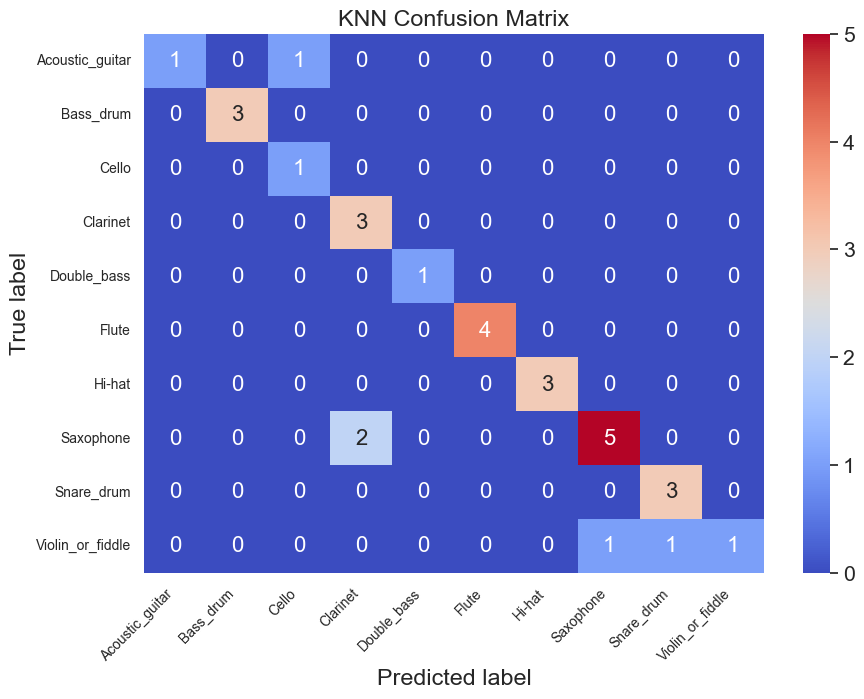

['instrument_models/kaggle_models/kaggle_knn.joblib']

In [8]:
# Define the parameter grid for the random search
param_grid = {
    'n_neighbors': randint(1, 15),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

knn = KNeighborsClassifier()

random_search_knn = RandomizedSearchCV(
    knn, param_distributions=param_grid, n_iter=10, cv=5, random_state=42
)
random_search_knn.fit(X_train, y_train)

best_knn = random_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test)
test_accuracy_knn = accuracy_score(y_test, y_pred_knn)

y_train_pred_knn = best_knn.predict(X_train)
train_accuracy_knn = accuracy_score(y_train, y_train_pred_knn)

print("Train KNN Accuracy:", train_accuracy_knn)
print("Test KNN Accuracy:", test_accuracy_knn)

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred_knn), index=label_mapping.keys(), columns=label_mapping.keys())

plt.figure(figsize=(10, 7))

sn.set(font_scale=1.4)
heatmap = sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap='coolwarm')

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=10)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('KNN Confusion Matrix')
plt.show()

# Save the model
joblib.dump(value=best_knn, filename="../instrument_models/kaggle_models/kaggle_knn.joblib")

In [9]:
from bidict import bidict
import librosa

audio, sr = librosa.load("wavfiles/juice_wrld_guitar.wav", sr=22050)

step = 3  # seconds
X_file = []
for index in range(0, len(audio) - step * sr, step * sr):
    sample = audio[index:index + step * sr]

    chroma_stft = librosa.feature.chroma_stft(y=sample, sr=sr)
    rms = librosa.feature.rms(y=sample)
    spectral_centroids = librosa.feature.spectral_centroid(y=sample, sr=sr)
    spectral_bandwidths = librosa.feature.spectral_bandwidth(y=sample, sr=sr)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=sample, sr=sr)
    zero_crossing_rates = librosa.feature.zero_crossing_rate(y=sample)
    chroma_cens = librosa.feature.chroma_cens(y=sample, sr=sr)
    tempo, _ = librosa.beat.beat_track(y=sample, sr=sr)
    mfccs = librosa.feature.mfcc(y=sample, sr=sr)

    sample_features = []
    sample_features.append(np.mean(chroma_stft))
    sample_features.append(np.var(chroma_stft))
    sample_features.append(np.mean(rms))
    sample_features.append(np.var(rms))
    sample_features.append(np.mean(spectral_centroids))
    sample_features.append(np.var(spectral_centroids))
    sample_features.append(np.mean(spectral_bandwidths))
    sample_features.append(np.var(spectral_bandwidths))
    sample_features.append(np.mean(spectral_rolloff))
    sample_features.append(np.var(spectral_rolloff))
    sample_features.append(np.mean(zero_crossing_rates))
    sample_features.append(np.var(zero_crossing_rates))
    sample_features.append(np.mean(chroma_cens))
    sample_features.append(np.var(chroma_cens))
    sample_features.append(tempo)
    for i, mfcc_column in zip(range(20), mfccs):
        sample_features.append(np.mean(mfcc_column))
        sample_features.append(np.var(mfcc_column))

    X_file.append(sample_features)

X_file = np.array(X_file)
X_file = scaler.transform(X_file)
print(X_file.shape)

label_dict = bidict(label_mapping)

y_file_predict = best_svm.predict(X_file)
y_file_predict = [label_dict.inverse[y_val] for y_val in y_file_predict]
print("SVM : ", y_file_predict)

y_file_predict = best_rf.predict(X_file)
y_file_predict = [label_dict.inverse[y_val] for y_val in y_file_predict]
print("RF : ", y_file_predict)

y_file_predict = best_knn.predict(X_file)
y_file_predict = [label_dict.inverse[y_val] for y_val in y_file_predict]
print("KNN : ", y_file_predict)

(7, 55)
SVM :  ['Saxophone', 'Saxophone', 'Saxophone', 'Saxophone', 'Saxophone', 'Saxophone', 'Saxophone']
RF :  ['Cello', 'Saxophone', 'Saxophone', 'Saxophone', 'Saxophone', 'Saxophone', 'Saxophone']
KNN :  ['Saxophone', 'Saxophone', 'Saxophone', 'Saxophone', 'Saxophone', 'Saxophone', 'Saxophone']


C:\Proiecte SSD\Licenta\Basic-Fourier-Usage\venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
